In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src import lda_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [36]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
n_topics = 20
max_doc_freq = 0.7
max_features = 10000
max_iterations = 25

lemmatized_tokens = wallstreet['processed_text']

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--- 
# Bag of Words

In [38]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = lda_utils.convert_to_bow_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
lda_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
drug consider ice arab sand nun smashed testicle eskimo deal

Topic #1:
order vendor support time day dispute wrote escrow buyer back

Topic #2:
use using vpn ip rdp system card one security information

Topic #3:
profile onion kallashnikov black supplier weed stealth wallstyizjhkrvmj high rated

Topic #4:
order utopia refund reship xa0 kush gramo gold customer btc

Topic #5:
bank chat log day room cashout one change fraud everythingcc

Topic #6:
market wsm profile store pm bump wrote listing offer vendor

Topic #7:
pgp signature message begin end signed hash key vendor version

Topic #8:
quality product order price best good shipping sample free offer

Topic #9:
know like wrote good make one money people work time

Topic #10:
use key mirror onionshop pgp click using tail message file

Topic #11:
passport fake offer license interested high quality driver com registered

Topic #12:
account card bank drop paypal transfer need cc money btc

Topic #13:
guide cashout bank record 

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


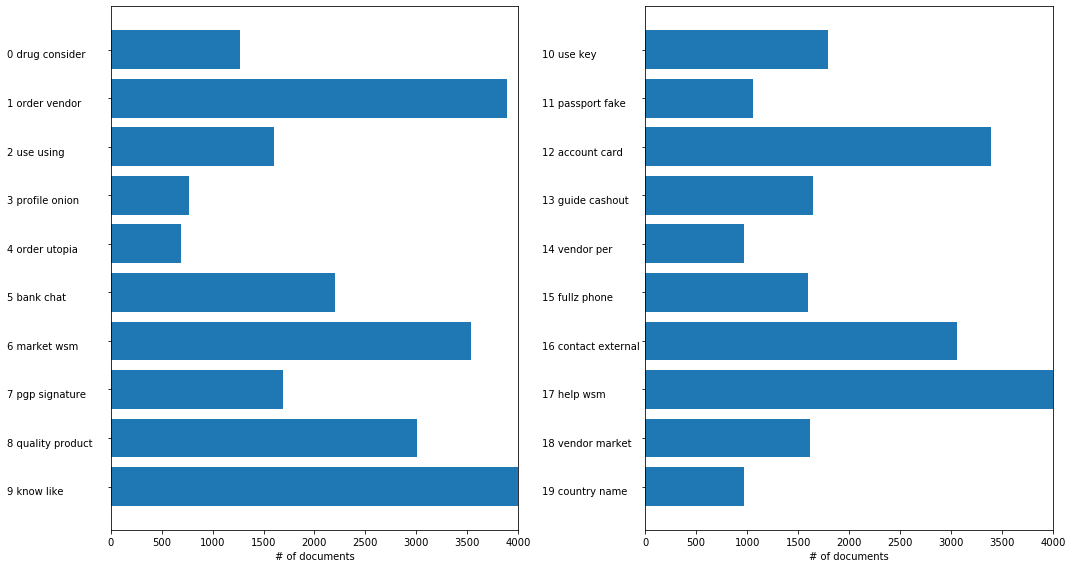

In [40]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 4000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [41]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.103326  0.060336       1        1  18.271751
1      0.091766 -0.013954       2        1   8.483251
2     -0.031161  0.095680       3        1   7.280802
8     -0.114331  0.006271       4        1   6.938560
12     0.061925  0.194218       5        1   6.839049
13     0.041664  0.203819       6        1   6.192973
18    -0.044645  0.003463       7        1   5.110769
17     0.216335 -0.124961       8        1   4.732911
10     0.073716 -0.012797       9        1   4.672559
5      0.124095  0.127480      10        1   4.310040
16     0.176790  0.012452      11        1   3.957203
15    -0.065467  0.151954      12        1   3.842732
6      0.104248 -0.117320      13        1   3.550419
4     -0.203636 -0.073308      14        1   3.139086
7      0.102951 -0.267837      15        1   2.569025
11    -0.117709  0.056099      16        1   2.278413
19    -0.239355 -0.003276      17        1   2.254725
14    -0.123843 -0.020617      18        1   2.174760
0      0.023348 -0.115876      19        1   1.961521
3     -0.180018 -0.161828      20        1   1.439451, topic_info=          Term          Freq         Total Category  logprob  loglift
5331    market  12303.000000  12303.000000  Default  30.0000  30.0000
9859       wsm  10682.000000  10682.000000  Default  29.0000  29.0000
734       bank  12189.000000  12189.000000  Default  28.0000  28.0000
4052      help   8455.000000   8455.000000  Default  27.0000  27.0000
7586      rule   7303.000000   7303.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
750        bar    140.291103    388.676849  Topic20  -5.0863   3.2219
9318       url    141.199773    474.473203  Topic20  -5.0799   3.0289
617         au    114.902528    224.964660  Topic20  -5.2859   3.5690
6052     offer    146.188804   8469.480606  Topic20  -5.0451   0.1816
935   bitcoins    109.649043    523.409643  Topic20  -5.3327   2.6778

[1465 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
8         4  0.958183          aaa
8        20  0.034221          aaa
9         1  0.399749           ab
9         4  0.034264           ab
9         7  0.424876           ab
...     ...       ...          ...
9950     13  0.992425  yourmomsbox
9967      6  0.062822        zelle
9967     10  0.926630        zelle
9980     20  0.995580           zu
9993     19  0.955857          для

[4848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 3, 9, 13, 14, 19, 18, 11, 6, 17, 16, 7, 5, 8, 12, 20, 15, 1, 4])

### Model Performance

In [42]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -11015787.623798076
Perplexity:  1130.6156875714353
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


---
# TF-IDF

In [43]:
def calculate_tfidf_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = TfidfVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = lda_utils.calculate_tfidf_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, 
                                                                                                                   n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
lda_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
ice sand arab nun smashed testicle eskimo consider drug deal

Topic #1:
order vendor wrote dispute note time market day know good

Topic #2:
card fullz cc credit need account rdp wrote scan info

Topic #3:
kallashnikov profile onion wallstyizjhkrvmj stealth supplier rated edition kallashnikovregister bestmarket

Topic #4:
bump store wsm market profile utopia xa0 samaritan kush gramo

Topic #5:
chat room log everythingcc day bank change cashout fraud one

Topic #6:
pm drop bank account market transfer looking paypal wrote need

Topic #7:
pgp signature begin message end signed hash version thanks key

Topic #8:
rule phished wsm help topic vendor closed forum allowed edited

Topic #9:
like wrote money know method need guide make people good

Topic #10:
mirror use onionshop key pgp tail using wallet tor message

Topic #11:
vouch review reserve com hi porn flight booking copy hotel

Topic #12:
interested italian selling rdps sim profile coke cc service stock

Topic #13:
guide cas

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.147692 -0.081908       1        1  25.069836
1      0.142800 -0.070109       2        1  13.208632
19     0.019028 -0.147749       3        1   7.932877
2      0.148743 -0.094447       4        1   6.984643
6      0.151735 -0.056882       5        1   6.071515
10     0.109060 -0.008698       6        1   5.182258
5      0.172314 -0.052816       7        1   4.841531
17     0.066177  0.183195       8        1   4.580101
13     0.028906  0.105977       9        1   4.193975
7     -0.028180  0.144223      10        1   3.134915
16     0.085286  0.107667      11        1   2.943625
4     -0.217923 -0.024711      12        1   2.611812
0      0.010833 -0.006360      13        1   2.156622
8     -0.024707  0.209786      14        1   1.955341
15    -0.244687 -0.095189      15        1   1.820186
3     -0.188829 -0.121407      16        1   1.665269
18    -0.120094  0.188446      17        1   1.507394
12    -0.066178 -0.083069      18        1   1.482900
11    -0.057795 -0.062138      19        1   1.419742
14    -0.134181 -0.033810      20        1   1.236827, topic_info=         Term         Freq        Total Category  logprob  loglift
1170     bump   879.000000   879.000000  Default  30.0000  30.0000
9859      wsm  1468.000000  1468.000000  Default  29.0000  29.0000
8383    store   801.000000   801.000000  Default  28.0000  28.0000
6467      pgp   685.000000   685.000000  Default  27.0000  27.0000
7586     rule  1080.000000  1080.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2580     done    14.067098   153.753383  Topic20  -5.1439   2.0011
846   believe    12.495658    94.603021  Topic20  -5.2623   2.3683
9423   vendor    17.842647  1140.085069  Topic20  -4.9061   0.2354
5857      new    13.373878   535.769001  Topic20  -5.1944   0.7022
1170     bump    13.024091   879.049498  Topic20  -5.2209   0.1806

[1350 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         4  0.091617          ___
1         7  0.045809          ___
1         9  0.091617          ___
1        12  0.641319          ___
1        15  0.091617          ___
...     ...       ...          ...
9936     14  0.941287        yoggy
9939      8  0.896232    yorkshire
9950      5  0.979424  yourmomsbox
9967      5  0.944548        zelle
9993     11  0.873925          для

[4741 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 20, 3, 7, 11, 6, 18, 14, 8, 17, 5, 1, 9, 16, 4, 19, 13, 12, 15])

In [47]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

C:\Users\morga\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -1621638.37
Perplexity:  6435.71
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


```
Log Likelihood:  -1624973.12
Perplexity:  7314.36
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
```